Objective: Create a Regression Model to predict the life expectancy and understand which factors are affecting life expectancy

# 0) Dependencise

In [887]:
import sys
from pathlib import Path

# data processing libraries
import pandas as pd
import numpy as np
import datetime
import re

# modeling 
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.ensemble import IsolationForest, RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, RFECV, SelectFromModel

# here put thoses algorithms
from sklearn.linear_model import LinearRegression, LassoCV


# metrics 
from scipy.optimize import least_squares
from sklearn.metrics import mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5] #change size of plot
import plotly.express as px

# 1) Data Acquistion

A quick look at:
1. Data Structure / Data Info
2. Categorical Variables
3. Numerical Variables

Data Dictionary:
- country: the country in which the indicators are from (i.e. United States of America or Congo)
- year: the calendar year the indicators are from (ranging from 2000 to 2015)
- status: whether a country is considered to be 'Developing' or 'Developed' by WHO standards
- life_expectancy: the life expectancy of people in years for a particular country and year

- adult_mortality (Ratio) - the adult mortality rate per 1000 population 
- infant_deaths (Ratio) - number of infant deaths per 1000 population; similar to above, but for infants
- alcohol (Ratio) - a country's alcohol consumption rate measured as liters of pure alcohol consumption per capita

- percentage_expenditure (Ratio) - expenditure on health as a percentage of Gross Domestic Product (gdp)
- hepatitis_b (Ratio): number of 1 year olds with Hepatitis B immunization over all 1 year olds in population
- measles (Number): number of reported Measles cases
- BMI: average Body Mass Index (BMI) of a country's total population

- under-five_deaths (Ratio) - number of people under the age of five deaths per 1000 population
- polio (Ratio) - number of 1 year olds with Polio immunization over the number of all 1 year olds in population
- total_expenditure (Ratio) - government expenditure on health as a percentage of total government expenditure
- diphtheria (Ratio) - Diphtheria tetanus toxoid and pertussis (DTP3) immunization rate of 1 year olds
- hiv/aids (Ratio) - deaths per 1000 live births caused by HIV/AIDS for people under 5; number of people under 5 who die due to HIV/AIDS per 1000 births

- gdp: Gross Domestic Product per capita ($USD)
- population: population of a country

- thinness_1-19_years (Ratio) - rate of thinness among people aged 10-19 
- thinness_5-9_years (Ratio) - rate of thinness among people aged 5-9
- income_composition_of_resources (Ratio) - Human Development Index in terms of income composition of resources (index ranging from 0 to 1)

- schooling (Number) - average number of years of schooling of a population

In [565]:
life_expectancy_data = pd.read_csv("Life Expectancy Data.csv")

## 1.1) A quick look at the data

In [ ]:
life_expectancy_data.shape

In [ ]:
life_expectancy_data.head()

In [ ]:
life_expectancy_data.columns

In [566]:
# Trim the spaces in the column names
trimed_col = []
for col in life_expectancy_data.columns:
    trimed_name = col.strip()
    trimed_name = trimed_name.replace("  "," ")

    if trimed_name not in ['BMI', 'HIV/AIDS','GDP']:
        trimed_col.append(trimed_name.title())
    else:
        trimed_col.append(trimed_name)
    
life_expectancy_data.columns = trimed_col

# Note that according to the data dictionary, the first column of thinness represent
# Rate of thinness among people aged 10-19. Hence we should rename the column from '1-19' to '10-19'.
life_expectancy_data.rename(columns = {'Thinness 1-19 Years':'Thinness 10-19 Years'},inplace = True)
life_expectancy_data.columns

Index(['Country', 'Year', 'Status', 'Life Expectancy', 'Adult Mortality',
       'Infant Deaths', 'Alcohol', 'Percentage Expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'Under-Five Deaths', 'Polio', 'Total Expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'Thinness 10-19 Years',
       'Thinness 5-9 Years', 'Income Composition Of Resources', 'Schooling'],
      dtype='object')

In [ ]:
life_expectancy_data.describe()

In [ ]:
life_expectancy_data.isnull().sum()

In [569]:
IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

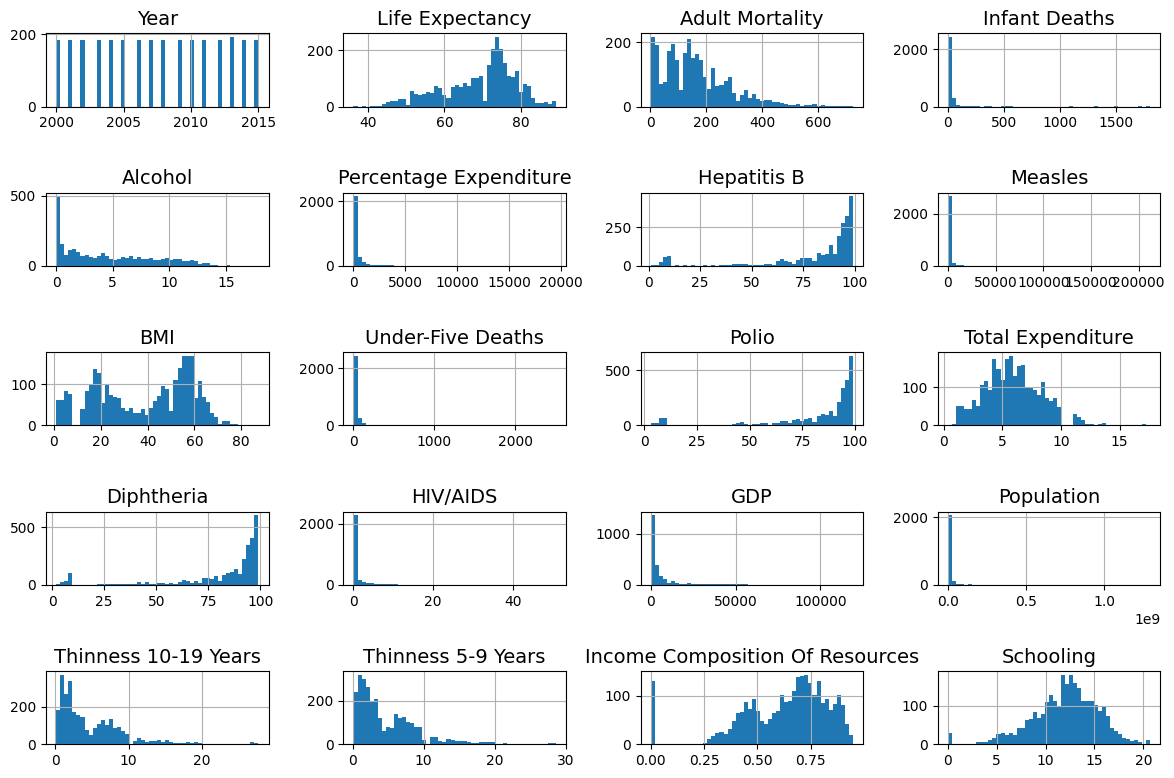

In [570]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

life_expectancy_data.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  
plt.show()

## 1.2) Pandas Profiling

Pandas Profiling generates a global deatiled report about the dataset, including the number of records, the number of features, overall missingness and duplicates. It also includes descriptive statistics for each individual variables and correlation statistics between the variables. Refer to 'original_dataset.html' to see the report.

In [ ]:
import pandas_profiling

profile = life_expectancy_data.profile_report(title='Pandas Profiling Report')
profile.to_file("original_dataset.html")

## 1.3) Data Correction

Looking at the above data distribution, we can immediately tell that some values are off.

- **Percentage Expenditure** as the current health percentage of GDP should be a percentage, it cannot go over the range of [0,100]. While in this dataset it has a range from [0,19479] and a mean of 738, this data should be wrong.
- **BMI** as a obesity indicateor usually range from [17,30], again this data is completely off.
- The overall distribution of **GDP** and **Population** seems valid, but they have many small values that do not make sense (for example, some countries have population < 50), and they have over 30% of the missing value.

The good news is all these common information can easily be found online. To improve the data quality, I replaced these features with actual dataset retrieved from WHO, OurWorldInData, and DataWorldBank.


In [571]:
df = life_expectancy_data.copy()

In [572]:
pop = pd.read_csv("Population-DataWorldBank.csv")

df = pd.merge(df, pop, how='left', on = ['Country', 'Year'])
df = df.drop(columns = 'Population')
df = df.rename(columns={'Value':'Population'})

df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life Expectancy                     10
Adult Mortality                     10
Infant Deaths                        0
Alcohol                            194
Percentage Expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
Under-Five Deaths                    0
Polio                               19
Total Expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Thinness 10-19 Years                34
Thinness 5-9 Years                  34
Income Composition Of Resources    167
Schooling                          163
Population                         419
dtype: int64

The number of null value did not change, it is possible that the country names are different in the dataset.

In [573]:
df['Country'][df['Population'].isnull()].unique()

array(['Bahamas', 'Micronesia (Federated States of)', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'Slovakia',
       'The former Yugoslav republic of Macedonia',
       'Bolivia (Plurinational State of)', "Côte d'Ivoire", 'Congo',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Egypt', 'Gambia',
       'Iran (Islamic Republic of)', 'Kyrgyzstan',
       "Lao People's Democratic Republic", 'Republic of Korea',
       'Republic of Moldova', 'Cook Islands', 'Niue',
       'Saint Kitts and Nevis', 'Swaziland', 'Turkey',
       'United Kingdom of Great Britain and Northern Ireland',
       'United Republic of Tanzania', 'United States of America',
       'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Yemen'],
      dtype=object)

Use country_converter to unify the country name.

In [574]:
import country_converter as coco

df = life_expectancy_data.copy()
df['Country'] = coco.convert(names = df['Country'], to='name_short')

df['Country'].unique()

array(['Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia',
       'Azerbaijan', 'Bahamas', 'Czech Republic', 'Micronesia, Fed. Sts.',
       'St. Lucia', 'St. Vincent and the Grenadines',
       'Sao Tome and Principe', 'Slovakia', 'North Macedonia',
       'Bangladesh', 'Benin', 'Bolivia', 'Botswana', 'Brazil',
       'Burkina Faso', 'Burundi', "Cote d'Ivoire", 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo Republic', 'Costa Rica', 'Cuba',
       'North Korea', 'DR Congo', 'Djibouti', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Ethiopia', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti',
       'Honduras', 'India', 'Indonesia', 'Iran', 'Iraq', 'Italy',
       'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya',
       'Kyrgyz Republic', 'Laos', 'Lebanon', 'Lesotho', 'Libe

In [ ]:
import country_converter as coco

pop = pd.read_csv("Population-DataWorldBank.csv")
pop['Country'] = coco.convert(names = pop['Country'], to='name_short')

df = pd.merge(df, pop, how='left', on = ['Country', 'Year'])
df = df.drop(columns = 'Population')
df = df.rename(columns={'Value':'Population'})

In [576]:
df['Population'].isnull().sum()

2

The number of null value significantly decrease! The assumption on the difference between country names was correct.

Coundct the same steps for all the datasets.

In [ ]:
# GDP per capital
gdp = pd.read_csv("GDP-DataWorldBank.csv")
gdp['Country'] = coco.convert(names = gdp['Country'], to='name_short')

df = pd.merge(df, gdp, how='left', on = ['Country', 'Year'])
df = df.drop(columns = 'GDP')
df = df.rename(columns={'Value':'GDP'})

In [578]:
df['GDP'].isnull().sum()

2

In [579]:
# Current Health Expenditure (% of GDP)
che = pd.read_csv("CHE-WHO.csv")
che['Country'] = coco.convert(names = che['Country'], to='name_short')

df = pd.merge(df, che, how='left',on = ['Country', 'Year'])

df = df.drop(columns = {'Percentage Expenditure','Indicator','ParentLocation'})
df = df.rename(columns={'Value':'Percentage Expenditure'})

In [580]:
df['Percentage Expenditure'].isnull().sum()

84

It seems like the number of null values increased. However, according to the panda profiiling report, there are over 20% of the values are zero, which means over 600 records were pure zero.

In [581]:
df['Country'][df['Percentage Expenditure'].isnull()].unique()

array(['North Korea', 'Iraq', 'Libya', 'Somalia', 'South Sudan', 'Syria',
       'Zimbabwe', 'Timor-Leste', 'Afghanistan', 'Montenegro'],
      dtype=object)

In [ ]:
# Body Mass Index
bmi = pd.read_csv("BMI-OurWorldInData.csv")
bmi['Country'] = coco.convert(names = bmi['Country'], to='name_short')

df = pd.merge(df, bmi, how="left", on = ['Country', 'Year'])
df = df.drop(columns = {'BMI','Mean BMI (female)','Mean BMI (male)'})
df = df.rename(columns= {'Mean BMI':'BMI'})

In [583]:
df['BMI'].isnull().sum()

34

Likewise, I also found the dataset for those features that have a large number of null values or zeros:
- Infant Deaths: 28.9% zeros        ~= 875 records
- Under-Five Deaths: 26.7% Zeros    ~=784 records
- Hepatitis B: 18.8% Missing Values ~=552 records
- Measles: 33.5% zeros              ~=984 records

In [ ]:
# Infant Deaths
infant = pd.read_csv("InfantMortalityPer1000-DataWorldBank.csv")
infant['Country'] = coco.convert(names = infant['Country'], to='name_short')

df = pd.merge(df, infant, how='left', on = ['Country', 'Year'])
df = df.drop(columns = 'Infant Deaths')
df = df.rename(columns={'Value':'Infant Deaths'})

In [585]:
df['Infant Deaths'].isnull().sum()

2

In [ ]:
# Deaths Under 5
child = pd.read_csv("InfantMortalityPer1000-DataWorldBank.csv")
child['Country'] = coco.convert(names = child['Country'], to='name_short')

df = pd.merge(df, child, how='left', on = ['Country', 'Year'])
df = df.drop(columns = 'Under-Five Deaths')
df = df.rename(columns={'Value':'Under-Five Deaths'})

In [587]:
df['Under-Five Deaths'].isnull().sum()

2

In [ ]:
# Hep B
hepb = pd.read_csv("HepB-IMU-DataWorld.csv")
hepb['Country'] = coco.convert(names = hepb['Country'], to='name_short')

df = pd.merge(df, hepb, how='left', on = ['Country', 'Year'])
df = df.drop(columns = 'Hepatitis B')
df = df.rename(columns={'Value':'Hepatitis B'})

In [589]:
df['Hepatitis B'].isnull().sum()

562

It turns out that we do have a lot of missing information regarding Hepatitis B Immutization rate across countries.

In [590]:
# Measles
measles = pd.read_csv("Measles-OurWorldInData.csv")
measles['Country'] = coco.convert(names = measles['Country'], to='name_short')

df = pd.merge(df, measles, how='left', on = ['Country', 'Year'])
df = df.drop(columns = 'Measles')
df = df.rename(columns={'Value':'Measles'})

In [591]:
df['Measles'].isnull().sum()

162

In [593]:
df.to_csv('new_LifeExp.csv')

## 1.4) A quick look at the new data

In [594]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life Expectancy                     10
Adult Mortality                     10
Alcohol                            194
Polio                               19
Total Expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
Thinness 10-19 Years                34
Thinness 5-9 Years                  34
Income Composition Of Resources    167
Schooling                          163
Population                           2
GDP                                  2
Percentage Expenditure              84
BMI                                 34
Infant Deaths                        2
Under-Five Deaths                    2
Hepatitis B                        562
Measles                            162
dtype: int64

In [ ]:
df.describe()

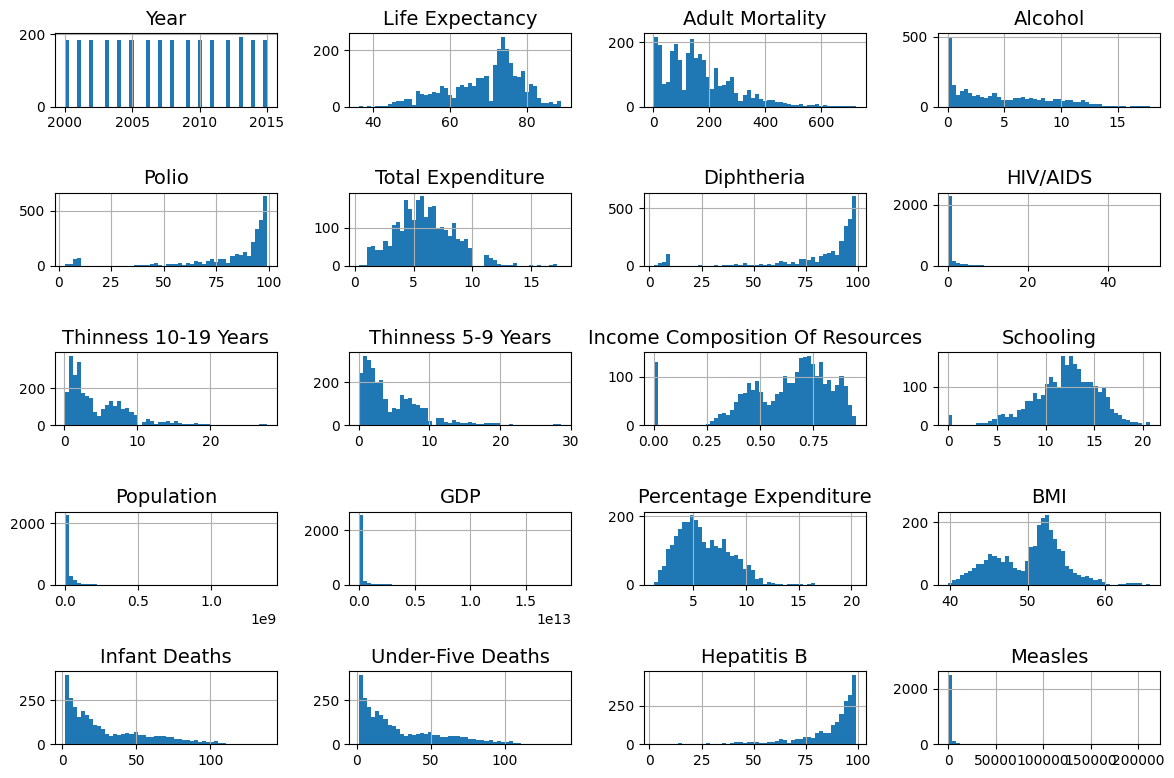

In [596]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
save_fig("new_attribute_histogram_plots")  
plt.show()

## 1.5) Sample a test set (remain unseen)

### 1.5.1) Method 1:  Randomly split the data using np.randodm.permutation

In [ ]:
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
np.random.seed(123)

train_set, test_set = shuffle_and_split_data(df, 0.2)

print(len(train_set),len(test_set))

In [ ]:
train_set.isnull().sum()

In [ ]:
test_set.isnull().sum()

### 1.5.2) Method 2: Using hash() function

In [ ]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
df_with_id = df.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(df_with_id, 0.2, "index")

In [ ]:
print(len(train_set),len(test_set))

In [ ]:
train_set.isnull().sum()

In [ ]:
test_set.isnull().sum()

### 1.5.3) Method 3: Using sklearn model selection

In [607]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=123)

In [608]:
print(len(train_set),len(test_set))

2350 588


In [609]:
train_set.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life Expectancy                      5
Adult Mortality                      5
Alcohol                            166
Polio                               17
Total Expenditure                  190
Diphtheria                          17
HIV/AIDS                             0
Thinness 10-19 Years                28
Thinness 5-9 Years                  28
Income Composition Of Resources    138
Schooling                          136
Population                           1
GDP                                  1
Percentage Expenditure              69
BMI                                 27
Infant Deaths                        1
Under-Five Deaths                    1
Hepatitis B                        452
Measles                            122
dtype: int64

In [610]:
test_set.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life Expectancy                      5
Adult Mortality                      5
Alcohol                             28
Polio                                2
Total Expenditure                   36
Diphtheria                           2
HIV/AIDS                             0
Thinness 10-19 Years                 6
Thinness 5-9 Years                   6
Income Composition Of Resources     29
Schooling                           27
Population                           1
GDP                                  1
Percentage Expenditure              15
BMI                                  7
Infant Deaths                        1
Under-Five Deaths                    1
Hepatitis B                        110
Measles                             40
dtype: int64

# 2) Data Exploration

Again I used panda profiling to explore the following:
- Descriptive Statistics
- Missing Data (%)
- Duplicates (%)
- Correlation


In [760]:
le = train_set.copy()

## 2.1) Pandas Profiling

Refer to 'output.html' to see the report.

In [612]:
import pandas_profiling

#le.profile_report(style = {'full_width':True})
#profile = le.profile_report()
#rejected_varaibles = profile.get_rejected_variables(threshold=0.9)

profile = le.profile_report(title='Pandas Profiling Report')
#profile.to_widgets()
profile.to_file("output.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s]


### 2.2) Correlation HeatMap

In [613]:
corr_matrix = le.corr()

In [614]:
corr_matrix['Life Expectancy'].sort_values(ascending = False)

Life Expectancy                    1.000000
Schooling                          0.745804
Income Composition Of Resources    0.723432
BMI                                0.603076
Diphtheria                         0.479610
Polio                              0.470865
Alcohol                            0.408048
Percentage Expenditure             0.325902
Hepatitis B                        0.310618
GDP                                0.223482
Total Expenditure                  0.214701
Year                               0.169231
Population                         0.025387
Measles                           -0.170507
Thinness 5-9 Years                -0.469094
Thinness 10-19 Years              -0.476461
HIV/AIDS                          -0.562711
Adult Mortality                   -0.700114
Infant Deaths                     -0.913420
Under-Five Deaths                 -0.913420
Name: Life Expectancy, dtype: float64

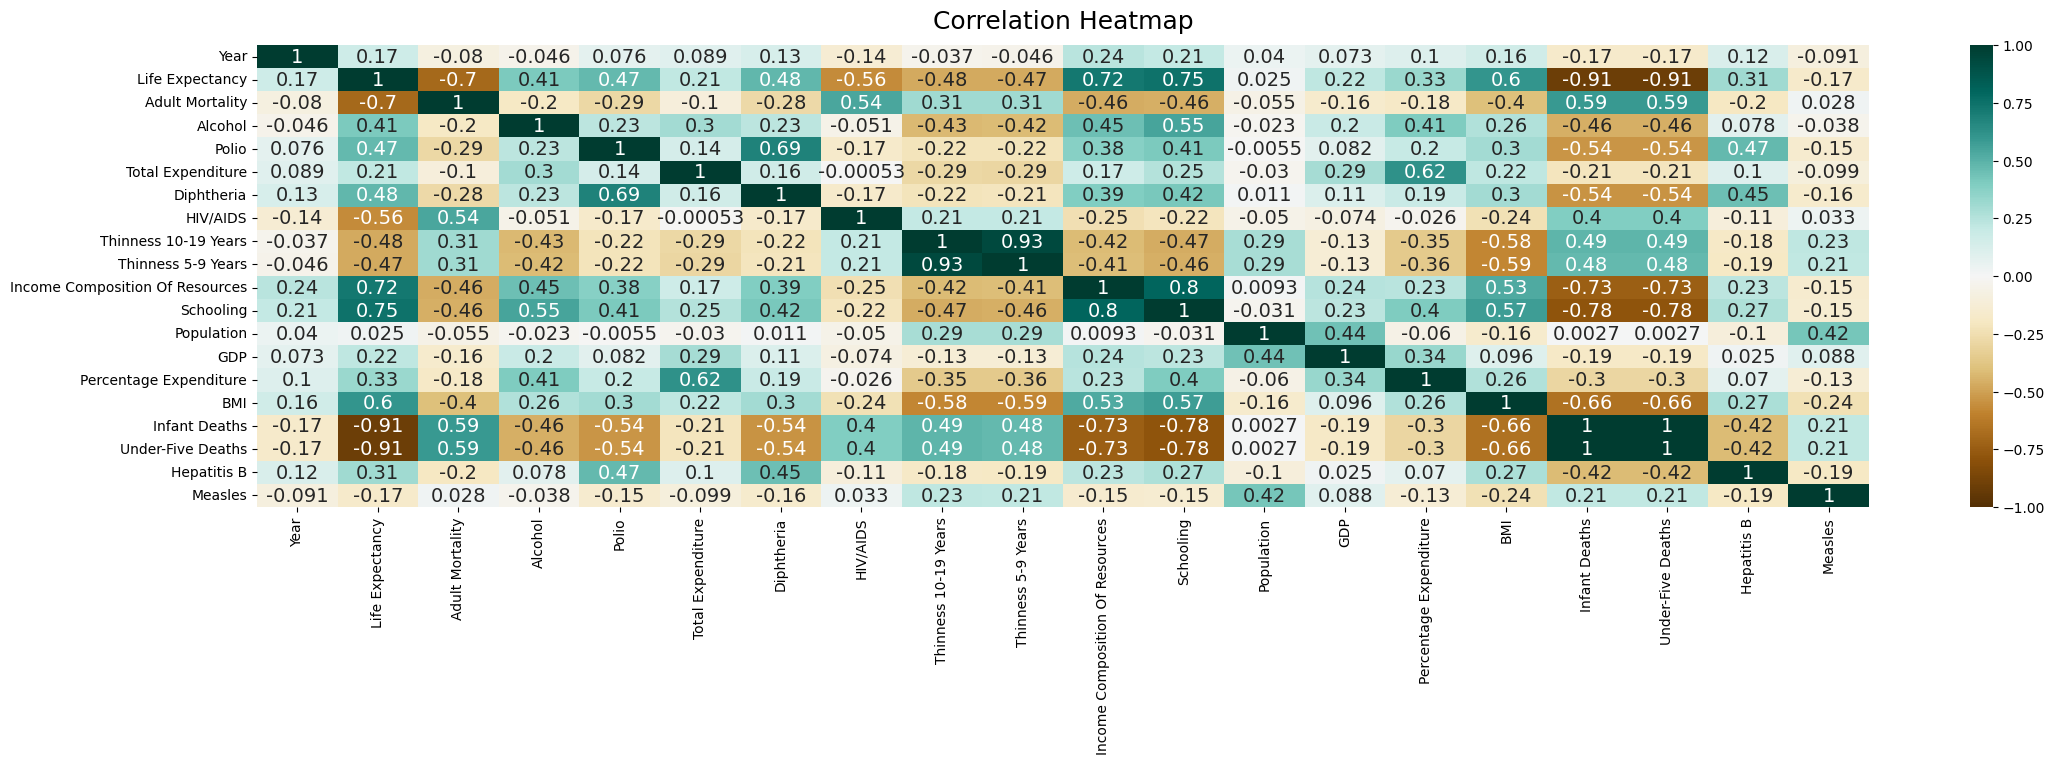

In [615]:
# check if there is any collinearity between variables
plt.figure(figsize=(26,6))
heatmap = sns.heatmap(le.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

path = IMAGES_PATH / 'heatmap.png'
plt.savefig(path, dpi=300, bbox_inches='tight')
    

According to the heatmap, the following pair of variables are highly correlated:
- "Thinness 10-19 Years" and "Thinness 5-9 Years"
- "Infant Deaths" and "Under-Five Deaths"
- 'Income Composition of Resources" and "Schooling"

For each pair, drop the one that is less correlated with 'Life Expectancy'.

In [761]:
le = le.drop(columns={'Thinness 10-19 Years','Under-Five Deaths','Schooling'})
le.shape

(2350, 19)

To further explore the relationship between LifeExpectancy and each independent variable, certain data cleaning needs to be done.

# 3) Data Cleaning

1. Dealing with Missing data
2. Outlier Detection
3. Handling Multi-Conllinearity
4. Data Preprocessing
5. Feature Selection
6. Feature engineering
7. Feature Scaling
8. Clustering
9. Imbalanced data

In [762]:
le.describe()

,Year,Life Expectancy,Adult Mortality,Alcohol,Polio,Total Expenditure,Diphtheria,HIV/AIDS,Thinness 5-9 Years,Income Composition Of Resources,Population,GDP,Percentage Expenditure,BMI,Infant Deaths,Hepatitis B,Measles
count,2350.000000,2345.000000,2345.000000,2184.000000,2333.000000,2160.000000,2333.000000,2350.000000,2322.000000,2212.000000,2.349000e+03,2.349000e+03,2281.000000,2323.000000,2349.000000,1898.000000,2228.000000
mean,2007.454894,69.179872,166.401279,4.739125,82.731247,5.957917,82.168881,1.784000,4.835659,0.626455,3.651778e+07,3.167070e+11,5.987067,50.396512,30.624819,85.254478,2404.757181
std,4.624086,9.612248,124.767660,4.097115,23.081076,2.484134,23.937718,5.106355,4.501963,0.213880,1.339679e+08,1.277114e+12,2.486901,4.488411,27.803616,17.109035,11463.593833
min,2000.000000,36.300000,1.000000,0.010000,3.000000,0.650000,2.000000,0.100000,0.100000,0.000000,1.069400e+04,0.000000e+00,1.260000,39.729504,1.800000,5.000000,0.000000
25%,2003.000000,62.900000,74.000000,1.017500,78.000000,4.280000,78.000000,0.100000,1.500000,0.494000,2.175425e+06,4.714072e+09,4.130000,46.855045,7.900000,80.000000,0.000000
50%,2007.000000,72.000000,144.000000,3.900000,93.000000,5.780000,93.000000,0.100000,3.300000,0.677000,8.171966e+06,2.028963e+10,5.520000,51.358675,19.600000,92.000000,24.000000
75%,2011.000000,75.700000,229.000000,8.010000,97.000000,7.500000,97.000000,0.800000,7.200000,0.781000,2.578203e+07,1.372440e+11,7.720000,53.218797,48.500000,97.000000,421.250000
max,2015.000000,89.000000,723.000000,17.870000,99.000000,17.600000,99.000000,50.600000,28.600000,0.948000,1.379860e+09,1.820600e+13,20.410000,65.782690,138.100000,99.000000,212183.000000


## 3.1) Dealing with Missing Values

We consider three options for handling the missing values.
1. Drop the records that contain missing values
2. Drop the columns that contain missing values
3. Impute the missing values with mean/median/mode

In [763]:
# Identify percentage of null values in each column. (Can also be found in output.html)
le.isnull().sum()*100/le.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life Expectancy                     0.212766
Adult Mortality                     0.212766
Alcohol                             7.063830
Polio                               0.723404
Total Expenditure                   8.085106
Diphtheria                          0.723404
HIV/AIDS                            0.000000
Thinness 5-9 Years                  1.191489
Income Composition Of Resources     5.872340
Population                          0.042553
GDP                                 0.042553
Percentage Expenditure              2.936170
BMI                                 1.148936
Infant Deaths                       0.042553
Hepatitis B                        19.234043
Measles                             5.191489
dtype: float64

In [ ]:
null_rows_idx = le.isnull().any(axis=1)
le.loc[null_rows_idx].head()

In [618]:
le.loc[null_rows_idx].shape

(796, 22)

In [ ]:
# Drop rows with missing value
le_option1 = le.copy()
le_option1.dropna(inplace=True)
le_option1.loc[null_rows_idx].head()

,Country,Year,Status,Life Expectancy,Adult Mortality,Alcohol,Polio,Total Expenditure,Diphtheria,HIV/AIDS,...,Income Composition Of Resources,Schooling,Population,GDP,Percentage Expenditure,BMI,Infant Deaths,Under-Five Deaths,Hepatitis B,Measles


In [ ]:
# Drop columns withh missing value
le_option2 = le.copy()
le_option2.dropna(axis='columns',inplace=True)  # option 2
le_option2.loc[null_rows_idx].head()

In [ ]:
# Impute the missing values with statistical measures
le_option3 = le.copy()
le_option3.fillna(le_option3.mean(), inplace=True)  # or median() / mode()
le_option3.loc[null_rows_idx].head()

Hepatitis B has almost 20% missing value, simply dropping the records will result in huge data loss, therefore we abandon option1.

To see if we can apply option2, check the relationship between Hepatitis B and Life Expectancy.

In [633]:
corr_matrix['Life Expectancy']['Hepatitis B']

0.31061801684425433

<AxesSubplot: xlabel='Year'>

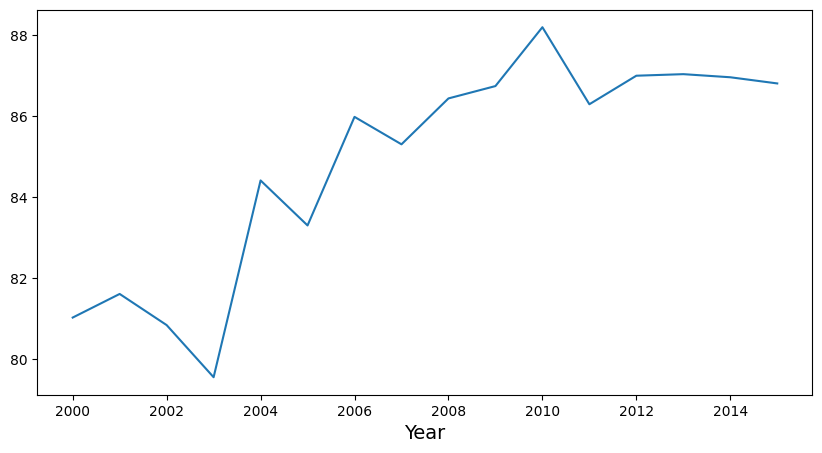

In [747]:
# Mean Hepatitis B Immunization Rate over Years
le.groupby('Year')['Hepatitis B'].mean().plot()

In [730]:
le['Hepatitis B'][le['Year']==2003].isnull().count()

147

It seems like there is a lot of value missing in the year of 2003. But in general it does show a linear relationship between Hepatitis B and Life Expectancy.

Move on to option 3.

<AxesSubplot: xlabel='Year'>

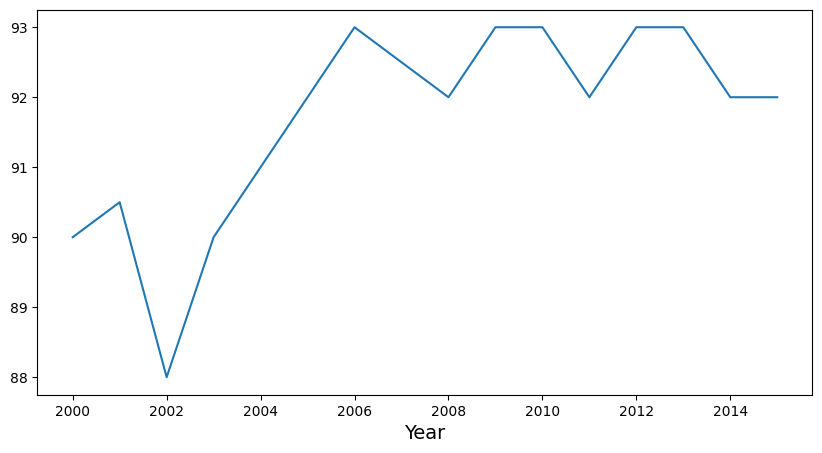

In [731]:
le.groupby('Year')['Hepatitis B'].median().plot()

Apply the same strategy to all columns with missing values.

In [764]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [765]:
# Separating out the numerical attributes to use the "median" strategy
le_num = le.select_dtypes(include=[np.number])

In [766]:
imputer.fit(le_num)

SimpleImputer(strategy='median')

In [735]:
imputer.statistics_

array([2.00700000e+03, 7.20000000e+01, 1.44000000e+02, 3.90000000e+00,
       9.30000000e+01, 5.78000000e+00, 9.30000000e+01, 1.00000000e-01,
       3.30000000e+00, 6.77000000e-01, 8.17196600e+06, 2.02896276e+10,
       5.52000000e+00, 5.13586754e+01, 1.96000000e+01, 9.20000000e+01,
       2.40000000e+01])

In [767]:
# Verify if imputer is working well
le_num.median().values

array([2.00700000e+03, 7.20000000e+01, 1.44000000e+02, 3.90000000e+00,
       9.30000000e+01, 5.78000000e+00, 9.30000000e+01, 1.00000000e-01,
       3.30000000e+00, 6.77000000e-01, 8.17196600e+06, 2.02896276e+10,
       5.52000000e+00, 5.13586754e+01, 1.96000000e+01, 9.20000000e+01,
       2.40000000e+01])

In [768]:
X = imputer.transform(le_num)

In [738]:
imputer.feature_names_in_

array(['Year', 'Life Expectancy', 'Adult Mortality', 'Alcohol', 'Polio',
       'Total Expenditure', 'Diphtheria', 'HIV/AIDS',
       'Thinness 5-9 Years', 'Income Composition Of Resources',
       'Population', 'GDP', 'Percentage Expenditure', 'BMI',
       'Infant Deaths', 'Hepatitis B', 'Measles'], dtype=object)

Now add the imputed value back to the dataframe

In [769]:
le[imputer.feature_names_in_] = X

#le_tr = pd.DataFrame(X, columns=le_num.columns, index=le_num.index)

In [ ]:
le.loc[null_rows_idx].head()

le.isnull().sum()

## 3.2) Outlier Detection

In [770]:
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

anomaly_values = le.iloc[outlier_pred == -1]

In [771]:
anomaly_values.shape

(276, 19)

Run the following cell to drop outlier

In [743]:
#le = le.iloc[outlier_pred == 1]
#le.shape

(2074, 19)

## 3.3) Feature Engineering

### 3.3.1) Handling Categorical Attributes

<AxesSubplot: >

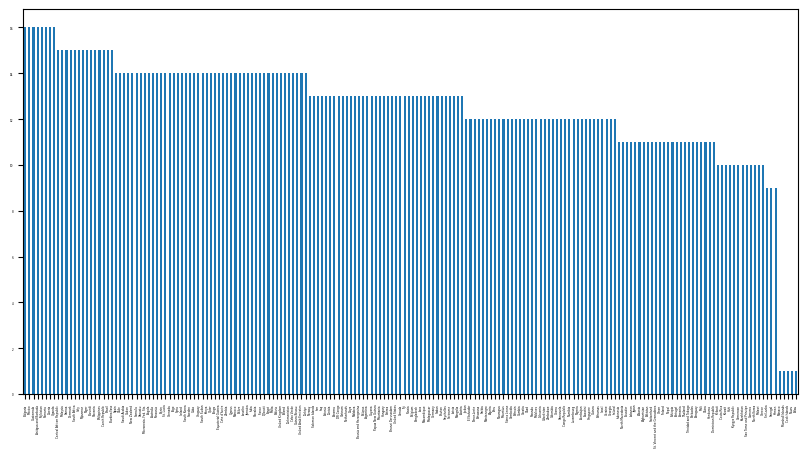

In [756]:
le['Country'].value_counts().plot(kind='bar', fontsize=2)

Country has a lot of unique value, using one-hot encodinig would result in a high dimensionality and could lead to overfitting. 

We could consider other encoding techniques such as Label Encoding. However, considering that we already have features like 'GDP per capital' and 'Population', it is not really necessary to include 'Country' becuase GDP and population likely capture much of the information that 'Country' can provide.

Therefore, simply drop this column.

In [ ]:
le = le.drop(columns='Country')
le.head()

The dataset only contains two different type of country status, therefore we can apply label encoing by assigning a value of 0 to one category and 1 to the other cateogry.

In [758]:
le['Status'].value_counts()

Developing    1921
Developed      429
Name: Status, dtype: int64

In [773]:
le['Status'] = LabelEncoder().fit_transform(le['Status'])
le['Status'].value_counts()

1    1921
0     429
Name: Status, dtype: int64

## 3.4) Feature Scaling

In [843]:
X = le.loc[:,le.columns != 'Life Expectancy']
y = le['Life Expectancy']

In [810]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
le_num_min_max_scaled = min_max_scaler.fit_transform(le_num)

In [811]:
std_scaler = StandardScaler()
le_num_std_scaled = std_scaler.fit_transform(le_num)

In [844]:
X_std = std_scaler.fit_transform(X)

## 3.5) Feature Selection

First use RFECV to determine the optimal number of features

In [845]:
reg =  LinearRegression()
selector = RFECV(estimator=reg,cv=5)
selector.fit(X_std,y)
X_new = selector.transform(X)

X_new

array([[2.00700000e+03, 1.00000000e+00, 9.00000000e+00, ...,
        5.19303479e+01, 1.53000000e+01, 9.80000000e+01],
       [2.00700000e+03, 1.00000000e+00, 1.24000000e+02, ...,
        5.31982342e+01, 1.10000000e+01, 9.40000000e+01],
       [2.00500000e+03, 1.00000000e+00, 2.38000000e+02, ...,
        5.06701142e+01, 3.34000000e+01, 9.30000000e+01],
       ...,
       [2.00500000e+03, 1.00000000e+00, 1.89000000e+02, ...,
        5.19932234e+01, 5.70000000e+00, 9.50000000e+01],
       [2.01000000e+03, 1.00000000e+00, 2.91000000e+02, ...,
        4.52739223e+01, 7.44000000e+01, 6.40000000e+01],
       [2.00600000e+03, 1.00000000e+00, 4.10000000e+01, ...,
        4.32784604e+01, 6.16000000e+01, 6.40000000e+01]])

In [846]:
selector.ranking_

array([1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4])

In [847]:
selector.n_features_

14

In [868]:
selected_features = selector.support_
selected_features

array([ True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False])

In [869]:
X.columns[selected_features]

Index(['Year', 'Status', 'Adult Mortality', 'Alcohol', 'Total Expenditure',
       'HIV/AIDS', 'Thinness 5-9 Years', 'Income Composition Of Resources',
       'Population', 'GDP', 'Percentage Expenditure', 'BMI', 'Infant Deaths',
       'Hepatitis B'],
      dtype='object')

Use LASSO to verify

In [863]:
lasso = LassoCV().fit(X_std, y)

importance_features = lasso.coef_ !=0
importance_features

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [865]:
X.columns[importance_features]

Index(['Year', 'Status', 'Adult Mortality', 'Alcohol', 'Total Expenditure',
       'Diphtheria', 'HIV/AIDS', 'Thinness 5-9 Years',
       'Income Composition Of Resources', 'Population', 'GDP',
       'Percentage Expenditure', 'BMI', 'Infant Deaths', 'Hepatitis B',
       'Measles'],
      dtype='object')

# 4) Modelling

0. Base Model
1. Training
2. Cross-Validation
3. Fine tuning
4. Evaluate on test set

## 4.1) Base Model

In [870]:
X = le.loc[:,le.columns != 'Life Expectancy']
y = le['Life Expectancy']

In [888]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

lr = LinearRegression()
cross_val_score(lr, X=X_std, y=y, cv=5)

array([0.90794586, 0.91303512, 0.91864926, 0.90300602, 0.9093713 ])

In [884]:
target_scaler = StandardScaler()
X_std = target_scaler.fit_transform(X)
scaled_labels = target_scaler.fit_transform(y.to_frame())

model = LinearRegression()
model.fit(X_std,scaled_labels)

some_new_data = X_std[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

predictions

array([[74.72449072],
       [74.87951994],
       [66.45847404],
       [73.78899739],
       [71.01996284]])

In [889]:
# Useful for applying a non-linear transformation to the target y in regression problems. 
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(X_std, y)
predictions = model.predict(some_new_data)

predictions

array([74.72449072, 74.87951994, 66.45847404, 73.78899739, 71.01996284])

# Transformation Pipelines

In [892]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [893]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [899]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

In [ ]:
le_num = le.select_dtypes(include=[np.number])

le_num_prepared = num_pipeline.fit_transform(le_num)

df_le_num_prepared = pd.DataFrame(
    le_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=le_num.index)

df_le_num_prepared.head(2)